In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from curve import Curve
from surface import Surface

%matplotlib inline

# Ellipse Sampling Demo

In [2]:
ellipse = Curve(
    lambda t: np.array([2*np.cos(t), np.sin(t)]), 
    lambda t: np.array([-2*np.sin(t), np.cos(t)]), 
    bounds=(0, 2*np.pi)
)

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains for 1_000 tune and 20 draw iterations (4_000 + 80 draws total) took 2 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


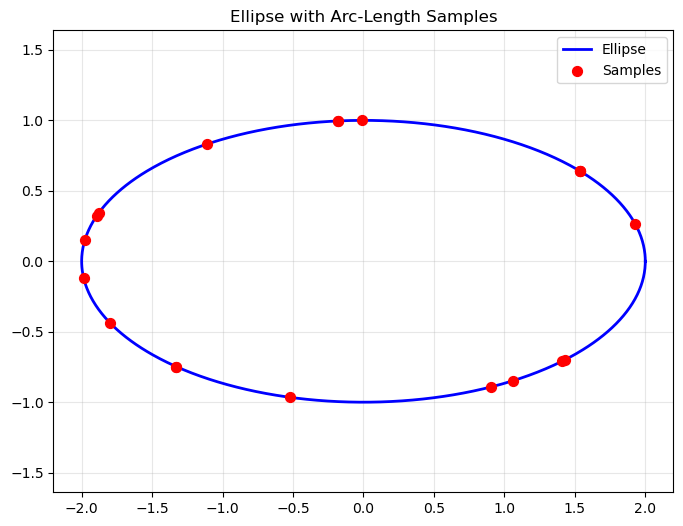

In [3]:
samples = np.array(ellipse.uniform_sample2(20))
t = np.linspace(*ellipse.bounds, 1000)
curve = np.array([ellipse.x(t_val) for t_val in t])

plt.figure(figsize=(8, 6))
plt.plot(curve[:, 0], curve[:, 1], 'b-', linewidth=2, label='Ellipse')
plt.scatter(samples[:, 0], samples[:, 1], color='red', s=50, zorder=5, label='Samples')
plt.title('Ellipse with Arc-Length Samples')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.legend()
plt.show()

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 25 seconds.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


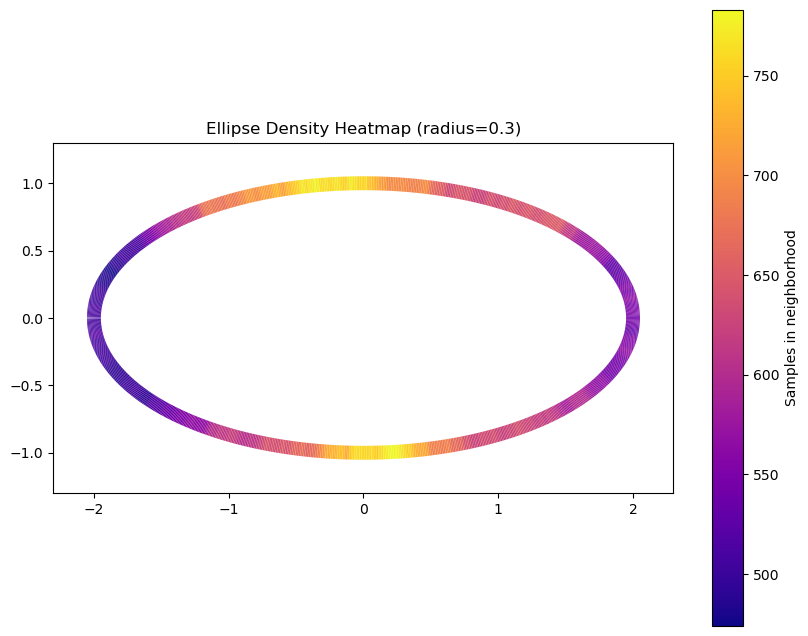

In [13]:
# Heatmap based on sample density
from matplotlib.collections import LineCollection

samples_heatmap = np.array(ellipse.uniform_sample2(10000))
radius = 0.3
densities = []
for pt in curve:
    count = np.sum(np.linalg.norm(samples_heatmap - pt, axis=1) < radius)
    densities.append(count)

# Create colored line segments
points = curve.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(vmin=min(densities), vmax=max(densities))

fig, ax = plt.subplots(figsize=(10, 8))
lc = LineCollection(segments, cmap='plasma', norm=norm, linewidth=10)
lc.set_array(densities)
line = ax.add_collection(lc)
ax.set_xlim(curve[:, 0].min()-0.3, curve[:, 0].max()+0.3)
ax.set_ylim(curve[:, 1].min()-0.3, curve[:, 1].max()+0.3)
ax.set_aspect('equal')
plt.colorbar(line, ax=ax, label='Samples in neighborhood')
plt.title(f'Ellipse Density Heatmap (radius={radius})')
plt.show()


# Torus Sampling Demo


In [ ]:
# Vectorized torus example
def torus_chart(x):
    R, r = 1.0, 0.3
    u, v = x[0], x[1]
    x_coord = (R + r * np.cos(v)) * np.cos(u)
    y_coord = (R + r * np.cos(v)) * np.sin(u) 
    z_coord = r * np.sin(v)
    return np.array([x_coord, y_coord, z_coord])

# Compute pushforward (Jacobian matrix) for torus
def torus_pushforward(x):
    R, r = 1.0, 0.3
    u, v = x[0], x[1]
    
    # Partial derivatives with respect to u
    dx_du = -(R + r * np.cos(v)) * np.sin(u)
    dy_du = (R + r * np.cos(v)) * np.cos(u)
    dz_du = 0
    
    # Partial derivatives with respect to v
    dx_dv = -r * np.sin(v) * np.cos(u)
    dy_dv = -r * np.sin(v) * np.sin(u)
    dz_dv = r * np.cos(v)
    
    # Return Jacobian matrix (3x2 matrix)
    return np.array([[dx_du, dx_dv],
                     [dy_du, dy_dv],
                     [dz_du, dz_dv]])

torus = Surface(torus_chart, pushforward=torus_pushforward, t_bounds=(0, 2*np.pi), s_bounds=(0, 2*np.pi))


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [xy]


Output()

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


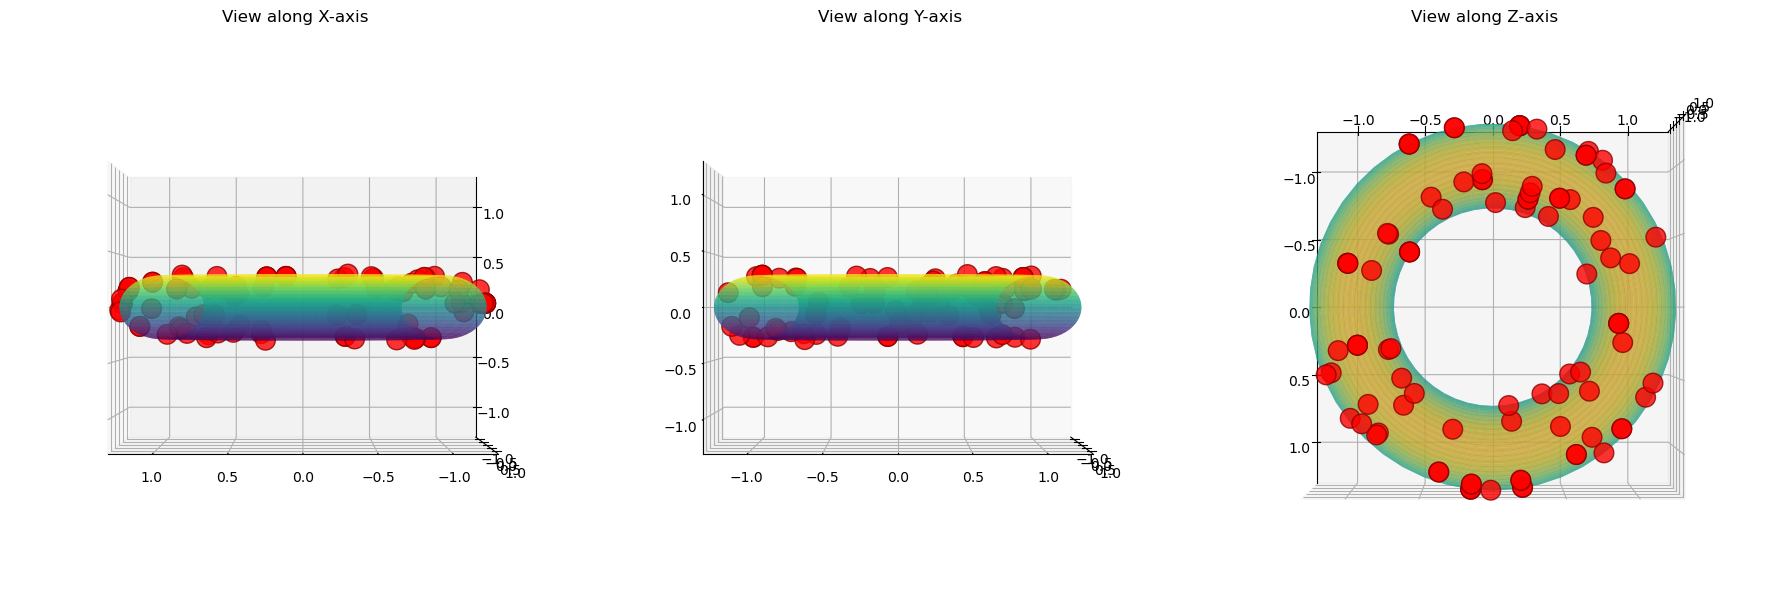

In [ ]:
samples = np.array(torus.uniform_sample(100))

# Create surface mesh
T, S = np.meshgrid(np.linspace(0, 2*np.pi, 50), np.linspace(0, 2*np.pi, 50))
coords = np.stack([T, S], axis=0)
X, Y, Z = torus_chart(coords)

# Set equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid = [(X.max()+X.min())/2, (Y.max()+Y.min())/2, (Z.max()+Z.min())/2]

# Plot from three different views
views = [(0, 90, 'X-axis'), (0, 0, 'Y-axis'), (90, 0, 'Z-axis')]
fig = plt.figure(figsize=(18, 6))

for i, (elev, azim, title) in enumerate(views, 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6, linewidth=0)
    ax.scatter(*samples.T, color='red', s=200, alpha=0.8, edgecolors='darkred', linewidth=1)
    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(f'View along {title}')

plt.tight_layout()
plt.show()
